In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout,  Activation
from keras.utils import to_categorical
from keras.optimizers import SGD


from google.colab import drive
drive.mount("/content/gdrive")

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
drive_base_path = "/content/gdrive/My Drive/Minor Project/"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [3]:
directory_images = os.listdir(path_to_images)
image_file = directory_images[100]
image_file[:-4]

'ISIC_0033427'

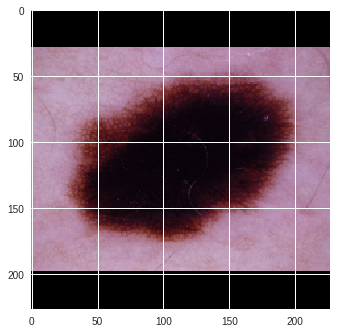

In [4]:
# # all image sizes are 600x450
# img = Image.open(path_to_images + image_file)
# plt.figure(0)
# plt.imshow(img)
# img  = img.resize((280, 210), Image.ANTIALIAS)
# print(img.size)
# plt.figure(1)
# plt.imshow(img)

INPUT_SIZE = 227

img = cv2.imread(path_to_images + image_file)
# parse BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
old_size = img.shape[:2] # height, width

# rescale
ratio = float(INPUT_SIZE)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# resize with new size
img = cv2.resize(img, (new_size[1], new_size[0])) # width, height
# plt.imshow(img)

# padding the image to make it a square
delta_w = INPUT_SIZE - new_size[1]
delta_h = INPUT_SIZE - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                            value=color)
#print(new_img)
plt.imshow(new_img)

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    data_format="channels_last")

In [0]:
def print_progress_bar(i, total):
    point = total / 100
    increment = total / 20
    
    if i % (2 * point) == 0:
        sys.stdout.write('\r')
        part1 = '=' * int(i / increment)
        part2 = ' ' * int((total - i)// increment)
        part3 = str(i / point)
        full = '[' + part1 + part2 + ']' + part3 + '%'
        sys.stdout.write(full)
        sys.stdout.flush()

In [0]:
def create_train_test(path_to_images, path_to_description, test_split=0.2, number=5000):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    current = 0
    # total = len(os.listdir(path_to_images))
    
    input_size = 227
    list_of_images = os.listdir(path_to_images)
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)
        
        
        arr = np.array(image)
        X_train.append(new_img)
    
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_train.append([int(float(x)) for x in row[1:]])
        
        print_progress_bar(current, number)
        current += 1
        
        if i == number:
            break
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_split, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [0]:
X_train, X_test, y_train, y_test = create_train_test(path_to_images, path_to_description)

In [0]:
with open(drive_base_path + "dataset/pickled-data/train_and_test_ISIC_2018_data.pkl", "wb") as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)

In [0]:
with open(drive_base_path + "dataset/pickled-data/train_and_test_ISIC_2018_data.pkl", "rb") as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [0]:
datagen.fit(X_train)

In [8]:
print("Training X Size", X_train.shape)
print("Training Y Size", y_train.shape)
for i in range(5):
    print(X_train[i].shape, y_train[i])

Training X Size (4000, 227, 227, 3)
Training Y Size (4000, 7)
(227, 227, 3) [0 1 0 0 0 0 0]
(227, 227, 3) [0 0 0 0 1 0 0]
(227, 227, 3) [0 1 0 0 0 0 0]
(227, 227, 3) [0 0 0 0 1 0 0]
(227, 227, 3) [0 1 0 0 0 0 0]


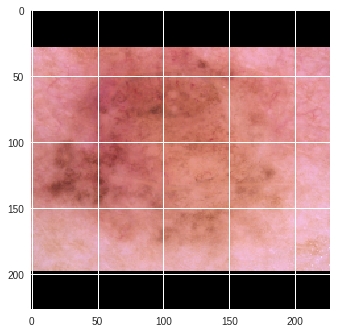

In [10]:
plt.imshow(X_train[100])

In [0]:
def create_alex_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation("relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation("relu"))
    # Add Dropout
    model.add(Dropout(0.4))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation("relu"))
    # Add Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(7))
    model.add(Activation("sigmoid"))
    
#     model.load
    
    return model

In [0]:
model = create_alex_net()
model.summary()
batch_size = 10
epochs = 5

In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train[1][0][0].ndim)

In [15]:
sgd = SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=10), epochs=epochs, verbose=1, validation_data=(X_test, y_test))
model.save_weights(drive_base_path + 'models/AlexNet_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

AttributeError: ignored

**MODEL VISUALIZATION**


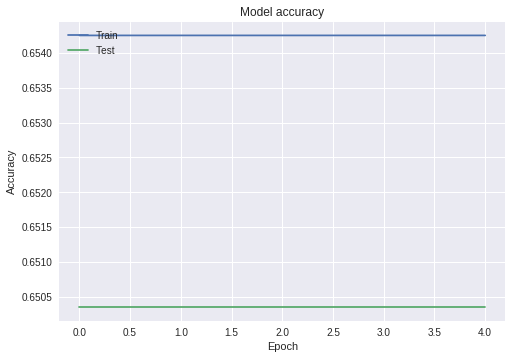

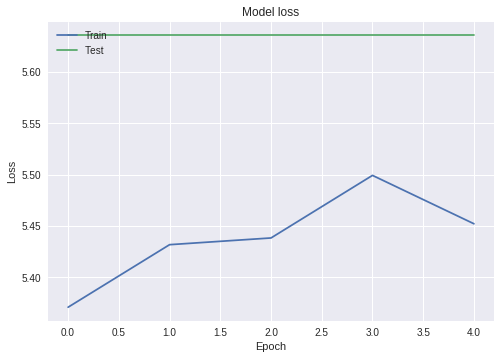

In [30]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()